### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

# Loading dataset

In [1]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 
#!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [2]:
#!pip install "opencv-python-headless<4.3"

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torchvision

In [4]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module


from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [5]:
#Traing dataset in gdrive.
#from google.colab import drive
#drive.mount('/content/gdrive')

In [6]:
import pathlib
import glob


x_train_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/leftImg8bit/train"))
y_train_seg_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/gtFine/train"))
y_train_dep_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/disparity/train"))

x_valid_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/leftImg8bit/val"))
y_valid_seg_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/gtFine/val"))
y_valid_dep_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/disparity/val"))

'''
x_train_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/train")
y_train_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/train")
y_train_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/train")

x_valid_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/val")
y_valid_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/val")
y_valid_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/val")

x_test_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/test")
y_test_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/test")
y_test_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/test")
'''

'\nx_train_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/train")\ny_train_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/train")\ny_train_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/train")\n\nx_valid_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/val")\ny_valid_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/val")\ny_valid_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/val")\n\nx_test_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/test")\ny_test_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/test")\ny_test_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/test")\n'

In [7]:
SIZE_X = 224 
SIZE_Y = 224

# Dataloader and utility functions 

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

In [9]:
from torch.utils.data import Dataset


# classes for data loading and preprocessing
class CityDataset(Dataset):
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            transform=None, 
            preprocessing=None,
    ):
        
        lis_x = sorted(os.listdir(images_dir)) 
        lis_y = sorted(os.listdir(masks_dir))

        self.images_fps = [image for link in lis_x for image in sorted(glob.glob(os.path.join(images_dir,link)+'/*.png'))]
        self.masks_fps = [image for link in lis_y for image in sorted(glob.glob(os.path.join(masks_dir,link)+'/*.png'))]
      
        self.transform = transform
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        sample = {}
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image, (SIZE_Y, SIZE_X))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample['image'] = image

        mask = cv2.imread(self.masks_fps[i])
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))

        sample['mask'] = mask
        
        # apply augmentations
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            #sample['image'] = self.transform(image=sample['image'])["image"].to(torch.float)
            #sample['mask'] = self.transform(image=sample['mask'])["image"].to(torch.int)

        # apply preprocessing
        if self.preprocessing:
            sample['image'] = self.preprocessing(sample['image'])
            #sample['mask'] = self.preprocessing(sample['mask'])
            #image, mask = sample['image'], sample['mask']          
 
        t= torchvision.transforms.ToTensor()
        
        sample['image'] = t(sample['image']).to(torch.float)
        sample['mask'] = t(sample['mask'][:,:,0]).to(torch.float)

        return sample
        
    def __len__(self):
        return len(self.images_fps)


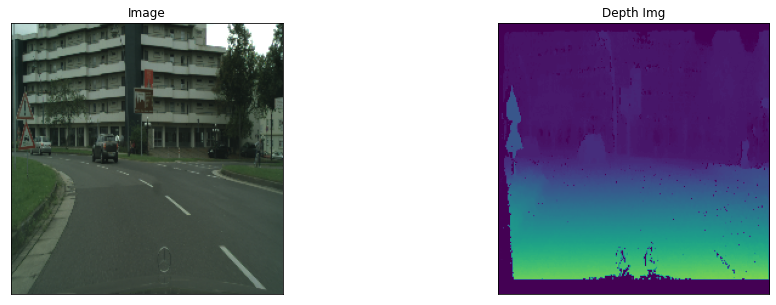

In [10]:
# Lets look at data we have
dataset = CityDataset(x_train_dir, y_train_dep_dir)

image = dataset[0]['image'] # get some sample
dep = dataset[0]['mask']

visualize(
    image=image.data.numpy().transpose(1,2,0), 
    depth_img=np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0),
)


### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [11]:
#!pip install -U albumentations
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


In [12]:
#import albumentations as A
#from albumentations.pytorch import ToTensorV2

In [13]:
#import albumentations as albu

In [14]:
'''
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [ToTensorV2()]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [ToTensorV2()]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)
'''

'\ndef round_clip_0_1(x, **kwargs):\n    return x.round().clip(0, 1)\n\n# define heavy augmentations\ndef get_training_augmentation():\n    train_transform = [ToTensorV2()]\n    return A.Compose(train_transform)\n\n\ndef get_validation_augmentation():\n    """Add paddings to make image shape divisible by 32"""\n    test_transform = [ToTensorV2()]\n    return A.Compose(test_transform)\n\ndef get_preprocessing(preprocessing_fn):\n    """Construct preprocessing transform\n    \n    Args:\n        preprocessing_fn (callbale): data normalization function \n            (can be specific for each pretrained neural network)\n    Return:\n        transform: albumentations.Compose\n    \n    """\n    \n    _transform = [\n        albu.Lambda(image=preprocessing_fn),\n        albu.Lambda(image=to_tensor, mask=to_tensor),\n    ]\n    return albu.Compose(_transform)\n'

In [15]:
import functools

def preprocess_input(x, mean=None, std=None, input_range=None, **kwargs):

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

def get_preprocessing_fn():
    formatted_settings = {}
    formatted_settings["input_range"] = [0, 1]
    formatted_settings["mean"] = [0.485, 0.456, 0.406]
    formatted_settings["std"] = [0.229, 0.224, 0.225]
    return functools.partial(preprocess_input, **formatted_settings)

In [16]:
dataset = CityDataset(x_train_dir, y_train_dep_dir,transform=None,preprocessing=get_preprocessing_fn())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


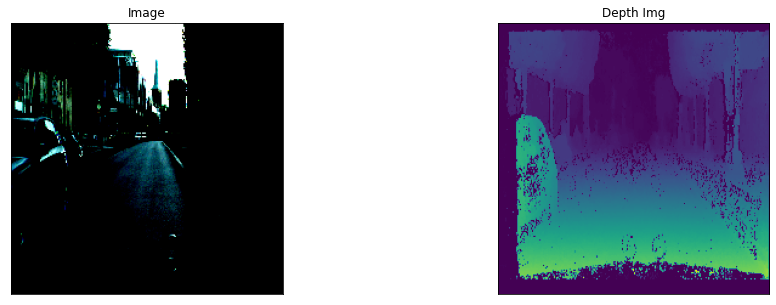

In [17]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
dep = dataset[ids]['mask']


visualize(
    image=image.data.numpy().transpose(1,2,0), 
    depth_img=np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0),
)

# Model parameters defination.

In [18]:
#Database.
Train_Batch_size = 8
Val_Batch_size = 8
nworkers = 4

#Optimiser and Scheduler.
epochs = 60
Lr = 0.0001

#Model Parameters
'''
CLASSES = ['road','sidewalk','building','wall','fence','pole',
                'traffic light','traffic sign','vegetation','terrain','sky',
                'person','rider','car','truck','bus',
                'train','motorcycle','bicycle','unlabeled']

#CLASSES = ['car', 'person']
Num_channels = 3

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation+ Background
activation = 'sigmoid' if n_classes == 1 else 'softmax'
'''
CLASSES = 1
Num_channels = 3

n_classes = 1

#task-type .
task_type = 'single'  # Select 'single' or 'multi'

In [19]:
import warnings

def get_output(output):
    output = output.permute(0, 2, 3, 1)
    #_, output = torch.max(output, dim=3)
    
    return output

#General Model evaluator
@torch.no_grad()
def eval_model_results(data_loader,model,n_classes=20, has_bg=False):
    total_rmses = 0.0
    total_log_rmses = 0.0
    n_valid = 0.0

    model.eval()
    for ii, sample in enumerate(data_loader):      
        inputimg, gt_masks = sample['image'].cuda(non_blocking=True), sample['mask'].cuda(non_blocking=True)
    
        output = model(inputimg)
        #output = F.softmax(output,dim=1)
           
        output = get_output(output)
        gt_masks = get_output(gt_masks)
        #print(gt_masks.shape,output.shape)

        for jj in range(int(inputimg.size()[0])):
            pred_dep = output[jj].cpu().data.numpy().squeeze()
            gt_dep = gt_masks[jj].cpu().data.numpy().squeeze()
  
            #Depth estimation.

            if pred_dep.shape != gt_dep.shape:
                warnings.warn('Prediction and ground truth have different size. Resizing Prediction..')
                pred_dep = cv2.resize(pred_dep, gt_dep.shape[::-1], interpolation=cv2.INTER_LINEAR)

            valid_mask = (gt_dep != 0)
            n_valid += np.sum(valid_mask)

            gt_dep[gt_dep == 0] = 1e-9 # Avoid overflow/underflow
            pred_dep[pred_dep <= 0] = 1e-9

            log_rmse_tmp = (np.log(gt_dep[valid_mask]) - np.log(pred_dep[valid_mask])) ** 2
            total_log_rmses += np.sum(log_rmse_tmp)

            rmse_tmp = (gt_dep[valid_mask] - pred_dep[valid_mask]) ** 2
            total_rmses += np.sum(rmse_tmp)
  
    # Write results
    eval_result = dict()
    eval_result['rmse'] = np.sqrt(total_rmses / n_valid)
    eval_result['log_rmse'] = np.sqrt(total_log_rmses / n_valid)

    return eval_result


In [20]:
#Directory for result storage.
def mkdir_if_missing(directory):
    if not os.path.exists(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

root = os.path.join(os.getcwd(),'results')

output_dir = os.path.join(root, 'CityScapes', 'UNet', 'depth_Baseline')
save_dir = os.path.join(output_dir, 'results')
checkpoint = os.path.join(output_dir, 'checkpoint.pth.tar')
best_model = os.path.join(output_dir, 'best_model.pth.tar')

mkdir_if_missing(output_dir)
mkdir_if_missing(save_dir)

#Training the model.

In [21]:
#Importing resnet backbone network
backbone = torchvision.models.resnet.resnet50(pretrained=True)
backbone_channels = 2048

In [22]:
#Designing a Resnet50 decoder.
class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x

class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)

class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


In [23]:
class UNet_Resnet50Decoder(nn.Module):
    DEPTH = 6

    def __init__(self,backbone, n_classes=2):
        super().__init__()
        resnet = backbone
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNet_Resnet50Decoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNet_Resnet50Decoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

In [24]:
#Model building.

model = UNet_Resnet50Decoder(backbone, n_classes=n_classes)
model.cuda()


UNet_Resnet50Decoder(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (input_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
   

In [25]:
#from torchsummary import summary

#print(summary(model,(Num_channels,SIZE_X,SIZE_Y)))

In [26]:
#define the crireia
class SingleTaskLoss(nn.Module):
    def __init__(self, loss_ft):
        super(SingleTaskLoss, self).__init__()
        self.loss_ft = loss_ft
        self.task = 'dep'
  
    def forward(self, pred, gt):
        out = {self.task: self.loss_ft(pred, gt)}
        out['total'] = out[self.task]
        return out


#Depth-loss
class DepthLoss(nn.Module):
    """
    Loss for depth prediction. By default L1 loss is used.  
    """
    def __init__(self, loss='l1'):
        super(DepthLoss, self).__init__()
        if loss == 'l1':
            self.loss = nn.L1Loss()

        else:
            raise NotImplementedError('Loss {} currently not supported in DepthLoss'.format(loss))

    def forward(self, out, label):
        mask = (label != 255)
        return self.loss(torch.masked_select(out, mask), torch.masked_select(label, mask))

criterion = SingleTaskLoss(DepthLoss())

if torch.cuda.is_available():
    criterion.cuda()

# define optomizer
optimizer = optim.Adam(model.parameters(), lr=Lr, weight_decay=1e-8)


In [27]:
# Dataset for train images
train_dataset = CityDataset(
    x_train_dir, 
    y_train_dep_dir, 
    transform=None,
    preprocessing=get_preprocessing_fn(), #smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS),
)

# Dataset for validation images
valid_dataset = CityDataset(
    x_valid_dir, 
    y_valid_dep_dir, 
    transform=None,
    preprocessing=get_preprocessing_fn(), #smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS),
)


In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=Train_Batch_size, shuffle=True,drop_last=True,
                              num_workers=nworkers )
valid_dataloader = DataLoader(valid_dataset, batch_size=Val_Batch_size, shuffle=False,drop_last=True,
                              num_workers=nworkers )


In [29]:
# PyTorch TensorBoard support
#from torch.utils.tensorboard import SummaryWriter
#from datetime import datetime

In [30]:
# Resume from checkpoint
loss_logger = []
Metrics_train_logger = []
Metrics_val_logger = []
if os.path.exists(checkpoint):
    checkpoint = torch.load(checkpoint, map_location='cpu')
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.load_state_dict(checkpoint['model'])
    start_epoch = checkpoint['epoch']
    best_result = checkpoint['best_result']
    loss_logger = checkpoint['loss_logger']
    Metrics_train_logger = checkpoint['Metrics_train_logger']
    Metrics_val_logger = checkpoint['Metrics_val_logger']
else:
    start_epoch = 0
    best_result = eval_model_results(valid_dataloader,model,n_classes=n_classes)

In [31]:
#Tracking functions.
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def get_loss_meters():
    """ Return dictionary with loss meters to monitor training """
    losses = {}
    losses['dep'] = AverageMeter('Loss %s' %('depth'), ':.4e')
    losses['total'] = AverageMeter('Loss Total', ':.4e')
    return losses


In [32]:
class DepthMeter(object):
    def __init__(self):
        self.total_rmses = 0.0
        self.total_log_rmses = 0.0
        self.n_valid = 0.0

    @torch.no_grad()
    def update(self, pred, gt):
        pred, gt = pred.squeeze(), gt.squeeze()
        
        # Determine valid mask
        mask = (gt != 0).bool()
        self.n_valid += mask.float().sum().item() # Valid pixels per image
        
        # Only positive depth values are possible
        pred = torch.clamp(pred, min=1e-9)
        gt = torch.clamp(gt, min=1e-9)
        
        # Per pixel rmse and log-rmse.
        log_rmse_tmp = torch.pow(torch.log(gt.to(torch.float)) - torch.log(pred.to(torch.float)), 2)
        log_rmse_tmp = torch.masked_select(log_rmse_tmp, mask)
        self.total_log_rmses += log_rmse_tmp.sum().item()

        rmse_tmp = torch.pow(gt - pred, 2)
        rmse_tmp = torch.masked_select(rmse_tmp, mask)
        self.total_rmses += rmse_tmp.sum().item()

    def reset(self):
        self.rmses = []
        self.log_rmses = []
        
    def get_score(self, verbose=True):
        eval_result = dict()
        eval_result['rmse'] = np.sqrt(self.total_rmses / self.n_valid)
        eval_result['log_rmse'] = np.sqrt(self.total_log_rmses / self.n_valid)

        if verbose:
            print('Results for depth prediction')
            for x in eval_result:
                spaces = ''
                for j in range(0, 15 - len(x)):
                    spaces += ' '
                print('{0:s}{1:s}{2:.4f}'.format(x, spaces, eval_result[x]))
                #print('{0:4f}{1:s}{2:.4f}'.format(self.total_rmses, spaces, self.n_valid))

        return eval_result
       
class PerformanceMeter(object):
    """ A general performance meter which shows performance across one or more tasks """
    def __init__(self,n_classes,cat_names,has_bg = False):
        self.meters = DepthMeter()

    def reset(self):
        self.meters.reset()

    def update(self, pred, gt):
        self.meters.update(pred, gt)

    def get_score(self, verbose=True):
        eval_dict = {}
        eval_dict['dep'] = self.meters.get_score(verbose)

        return eval_dict

In [33]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [34]:
def validate_results(current, reference):
    if current['log_rmse'] < reference['log_rmse']:
        print('New best depth estimation model %.3f -> %.3f' %(reference['rmse'], current['rmse']))
        improvement = True
    else:
        print('No new best depth estimation model %.3f -> %.3f' %(reference['rmse'], current['rmse']))
        improvement = False

    if improvement: # Return result
        return True, current
    else:
        return False, reference


In [35]:
def adjust_learning_rate(optimizer, epoch):
    """ Adjust the learning rate """
    lr = Lr

    lambd = pow(1-(epoch/epochs), 0.9)
    lr = lr * lambd

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

In [36]:
def train_vanilla(train_loader, model, criterion, optimizer, epoch):
    """ Vanilla training with fixed loss weights """
    avg_loss = 0
    num = 0
    losses = get_loss_meters()
    performance_meter = PerformanceMeter(n_classes,CLASSES,has_bg = False)
    progress = ProgressMeter(len(train_loader),
        [v for v in losses.values()], prefix="Epoch: [{}]".format(epoch))
    
    model.train()
    
    for i, batch in enumerate(train_loader):
        # Forward pass
        
        images = batch['image'].cuda(non_blocking=True)
        targets = batch['mask'].cuda(non_blocking=True)
        output = model(images)
        
        # Measure loss and performance
        loss_dict = criterion(output, targets)
        for k, v in loss_dict.items():
            losses[k].update(v.item())
        
        performance_meter.update(get_output(output),get_output(targets))
        
        # Backward
        optimizer.zero_grad()
        loss_dict['total'].backward()
        optimizer.step()

        if i % (Train_Batch_size-1) == 0:
            progress.display(i)
            
        with torch.no_grad():
            avg_loss += loss_dict['total']
            num += 1 

    eval_results = performance_meter.get_score(verbose = True)
    avg_loss = avg_loss.cpu() / num
    
    return eval_results,avg_loss

In [37]:

for epoch in range(start_epoch, epochs):
    print('Epoch {0}/{1}'.format(epoch+1, epochs))

    # Adjust lr
    if epoch > 40:
        lr = adjust_learning_rate(optimizer, epoch)
        print('Adjusted learning rate to {:.5f}'.format(lr))
  
    # Train 
    print('Train ...')
    eval_train,avg_loss = train_vanilla(train_dataloader, model, criterion, optimizer, epoch)
 
    loss_logger.append(avg_loss)
    Metrics_train_logger.append(eval_train)
    
    # Evaluate
    # Check if need to perform eval first
    if epoch + 1 > epochs - 30:
        eval_bool = True
    else:
        eval_bool = False

    # Perform evaluation
    if eval_bool:
        print('Evaluate ...')
        curr_result = eval_model_results(valid_dataloader,model,n_classes=n_classes)
        Metrics_val_logger.append(curr_result)
        improves, best_result = validate_results(curr_result, best_result)
        if improves:
            print('Save new best model')
            torch.save(model.state_dict(),best_model)

    # Checkpoint
    print('Checkpoint ...')
    
    torch.save({'optimizer': optimizer.state_dict(), 'model': model.state_dict(), 
                'epoch': epoch + 1, 'best_result': best_result,'loss_logger':loss_logger,
                'Metrics_train_logger':Metrics_train_logger,'Metrics_val_logger':Metrics_val_logger}, checkpoint)
    

Epoch 1/60
Train ...
Epoch: [0][ 0/92]	Loss depth 7.0139e-01 (7.0139e-01)	Loss Total 7.0139e-01 (7.0139e-01)
Epoch: [0][ 7/92]	Loss depth 2.0747e-01 (4.2076e-01)	Loss Total 2.0747e-01 (4.2076e-01)
Epoch: [0][14/92]	Loss depth 1.1407e-01 (2.9402e-01)	Loss Total 1.1407e-01 (2.9402e-01)
Epoch: [0][21/92]	Loss depth 8.2254e-02 (2.3113e-01)	Loss Total 8.2254e-02 (2.3113e-01)
Epoch: [0][28/92]	Loss depth 7.9976e-02 (1.9534e-01)	Loss Total 7.9976e-02 (1.9534e-01)
Epoch: [0][35/92]	Loss depth 7.0618e-02 (1.7191e-01)	Loss Total 7.0618e-02 (1.7191e-01)
Epoch: [0][42/92]	Loss depth 5.7671e-02 (1.5419e-01)	Loss Total 5.7671e-02 (1.5419e-01)
Epoch: [0][49/92]	Loss depth 5.6094e-02 (1.4067e-01)	Loss Total 5.6094e-02 (1.4067e-01)
Epoch: [0][56/92]	Loss depth 5.4267e-02 (1.3032e-01)	Loss Total 5.4267e-02 (1.3032e-01)
Epoch: [0][63/92]	Loss depth 8.2864e-02 (1.2185e-01)	Loss Total 8.2864e-02 (1.2185e-01)
Epoch: [0][70/92]	Loss depth 3.9535e-02 (1.1400e-01)	Loss Total 3.9535e-02 (1.1400e-01)
Epoch: [0][

# Evaluate the model

In [38]:
#model.load_state_dict(torch.load(best_model))
model.load_state_dict(torch.load(checkpoint)['model'])
Eval_stats = eval_model_results(valid_dataloader,model,n_classes=n_classes)

In [39]:
Eval_stats

{'rmse': 0.041791201802221546, 'log_rmse': 1.5206677635903953}

In [50]:
# Lets look at augmented data we have
dataset = CityDataset(x_valid_dir, y_valid_dep_dir,transform=None,preprocessing=get_preprocessing_fn())

In [54]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
dep = dataset[ids]['mask']

model.eval()

with torch.no_grad():
    output = model(image[None,:,:,:].cuda())
output = (output.squeeze().cpu().numpy())

In [55]:
output.shape

(224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


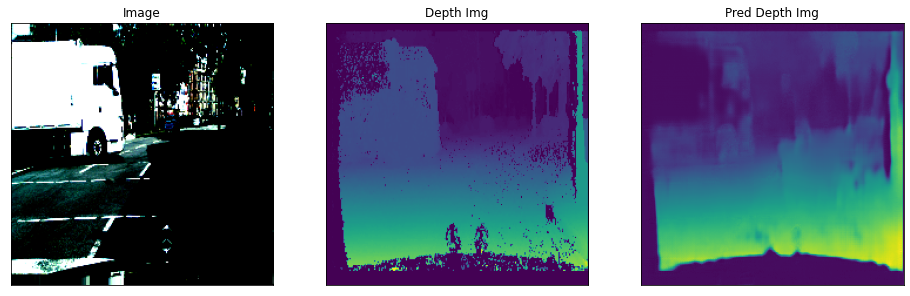

In [56]:
visualize(
    image=image.data.numpy().transpose(1,2,0), 
    depth_img=np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0),
    Pred_depth_img=np.stack(output[:,:]*3,axis=0)
)


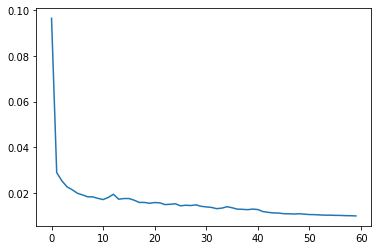

In [44]:
loss_logger = torch.load(checkpoint)['loss_logger']
plt.plot(loss_logger)

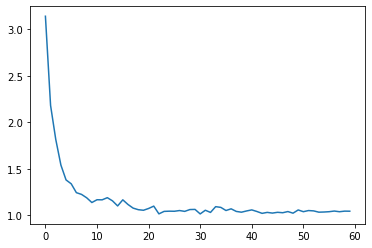

In [45]:
Metrics_train_logger = torch.load(checkpoint)['Metrics_train_logger']
plt.plot(Metrics_train_logger)

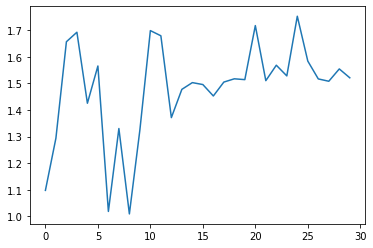

In [46]:
Metrics_val_logger = torch.load(checkpoint)['Metrics_val_logger']
plt.plot(Metrics_val_logger)